In [1]:
import pandas as pd
import config
import slm_utils
import miscellaneous_utils as mu
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller


In [2]:
def return_fst(host):
    
    pi_dir = "%s/pi/Poyet/%s" % (config.analysis_directory,host)
    
    good_species = [s[:-7] for s in os.listdir(pi_dir)]
    dates = mu.return_dates(host)

    all_samples = mu.return_host_samples(host)

    pi_df_BT = pd.DataFrame(columns=all_samples,index=good_species)
    pi_df_W = pd.DataFrame(columns=all_samples,index=good_species)

    for spc in good_species:
        pi_df = pd.read_csv("%s/%s_pi.txt" % (pi_dir,spc),index_col=0)
        pi_df_T = pd.DataFrame(columns=all_samples,index=all_samples)
        pi_df_T.loc[pi_df.index,pi_df.columns] = pi_df
        species_dates = dates.loc[pi_df.index].sort_values()
        first_date = species_dates.index[0]
        pi_df_BT.loc[spc] = pi_df_T.loc[first_date]
        pi_df_W.loc[spc] = np.diag(pi_df_T)

    
    pi_df_W = pi_df_W.loc[:,[d for d in dates.index if d in pi_df_W.columns]]
    pi_df_BT = pi_df_BT.loc[:,[d for d in dates.index if d in pi_df_BT.columns]]
    
    ## threshold by minimum number of samples being greater than 25, as in the strain inference parts of the paper
    pi_df_W = pi_df_W.loc[pi_df_W.T.notna().sum() > 25]
    pi_df_BT = pi_df_BT.loc[pi_df_W.index]

    ## calculate the mean between host (BH) diversity of each species, from inter-sample pi in HMP

    BH = {}
    for spcs in pi_df_W.index:
        pi_df_BH = pd.read_csv("/u/home/r/rwolff/diversity_ecology/analysis/pi/HMP1-2/%s/%s_pi.txt" % (spcs,spcs),index_col=0)
        xz = zip(np.triu_indices(n=pi_df_BH.shape[0],m=pi_df_BH.shape[1])[0],(np.triu_indices(n=pi_df_BH.shape[0],m=pi_df_BH.shape[1])[1]))
        xz = list(xz)
        BH[spcs] = 1-(pi_df_BH.values[xz].ravel().mean()-np.diag(pi_df_BH.values).mean())/pi_df_BH.values[xz].ravel().mean()
    
    BH = pd.Series(BH)
    
    Fst = 1-(pi_df_BT - pi_df_W)/pi_df_BT
    
    Fst = (BH/Fst.T).T
    return(Fst)

In [3]:
host = "am"
pi_dir = "%s/pi/Poyet/%s" % (config.analysis_directory,host)
spc = "Bacteroides_xylanisolvens_57185"
pi_df = pd.read_csv("%s/%s_pi.txt" % (pi_dir,spc),index_col=0)

In [3]:
Fst = return_fst(host)
dates = mu.return_dates(host)

NameError: name 'host' is not defined

In [35]:
H_all = {}
ts_all = {}
for host in ["ae","am","an","ao"]:
    H = {}
    ts = {}
    dates = mu.return_dates(host)
    Fst = return_fst(host)
    for s in Fst.index:
        st = s
        y = Fst.loc[s].dropna()
        H[st] = adfuller(y.values[1:])[1]
        ts[st] = (dates.loc[y.index].values,y.values)
    H_all[host] = H
    ts_all[host] = ts

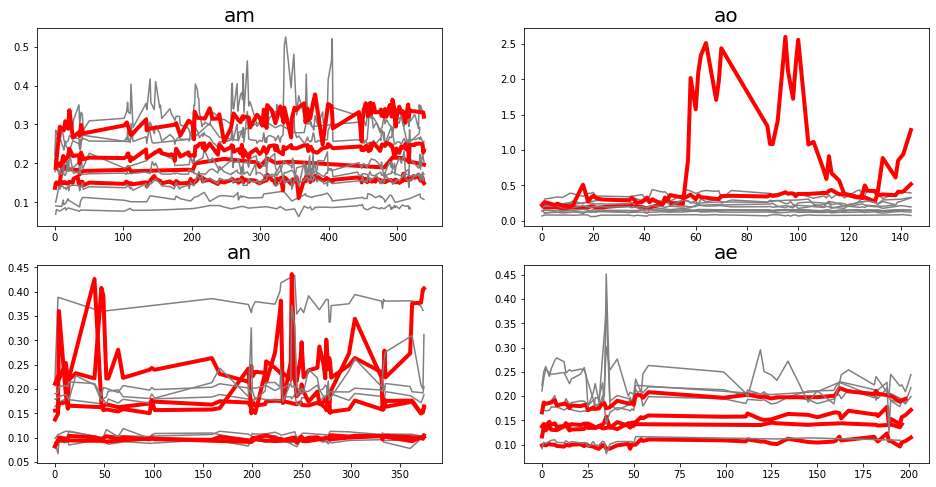

In [36]:
fig,axs = plt.subplots(2,2,figsize=(16,8))

axs = axs.ravel()

i = 0
for host in ["am","ao","an","ae"]:
    axs[i].set_title(host,size=20)
    for k in ts_all[host]:
        if H_all[host][k] > .05:
            axs[i].plot(ts_all[host][k][0],ts_all[host][k][1],color="red",lw=4)
        #ax.scatter(ts_all[host][k][0],ts_all[host][k][1],s=20,zorder=10,color="k")
        else:
            axs[i].plot(ts_all[host][k][0],ts_all[host][k][1],color="grey")
        #ax.scatter(ts_all[host][k][0],ts_all[host][k][1],zorder=4,color="k")

    #axs[i].semilogy()
    #if host == "ao":
    #    axs[i].set_ylim([.05,5])
    #else:
    #    axs[i].set_ylim([.05,1.75])
    
    #axs[i].axhline(1,ls="--")
    #axs[i].text(1, 1.1, r"Inter-host ${F_{ST}}'$", fontsize = 20,color="k")

    i += 1

In [37]:
f = 0
s = 0
for host in ["am","ao","an","ae"]:
    f+=(pd.Series(H_all[host]) > .05).sum()
    s+=pd.Series(H_all[host]).shape[0]

In [41]:
H_all["ae"]

{'Eubacterium_rectale_56927': 0.000102421534150879,
 'Alistipes_putredinis_61533': 0.29776092715888536,
 'Alistipes_onderdonkii_55464': 0.25489949916361454,
 'Bacteroides_uniformis_57318': 0.48146683177156024,
 'Bacteroides_massiliensis_44749': 0.0013229966061683522,
 'Bacteroides_vulgatus_57955': 7.324410667662467e-10,
 'Bacteroides_thetaiotaomicron_56941': 0.5031675293484418,
 'Bacteroides_ovatus_58035': 0.004531633857402193,
 'Bacteroides_cellulosilyticus_58046': 0.002032335452385336}

In [38]:
f

15

In [39]:
1-f*1.0/s

0.6666666666666667

In [8]:
host = "am"

df_strains = pd.read_csv("strains_%s.csv" % host,index_col=0)

In [9]:
H = {}
for s in df_strains.index:
    H[s] = adfuller(df_strains.loc[s].dropna().values)[1]



In [10]:
H_all = {}
ts_all = {}
for host in ["ae","am","an","ao"]:
    H = {}
    ts = {}
    dates = mu.return_dates(host)
    df_strains = pd.read_csv("strains_%s.csv" % host,index_col=0)
    for s in df_strains.index:
        st = s
        y = df_strains.loc[s].dropna()
        H[st] = adfuller(y.values)[1]
        ts[st] = (dates.loc[y.index].values,y.values)
    H_all[host] = H
    ts_all[host] = ts

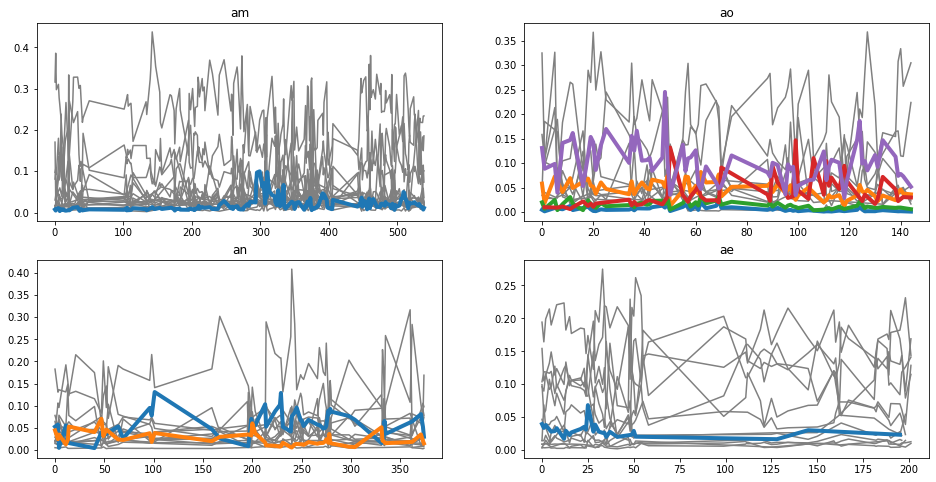

In [14]:
fig,axs = plt.subplots(2,2,figsize=(16,8))

axs = axs.ravel()

i = 0
for host in ["am","ao","an","ae"]:
    
    axs[i].set_title(host)
    for k in ts_all[host]:
        if H_all[host][k] > .05:
            axs[i].plot(ts_all[host][k][0],ts_all[host][k][1],lw=4,zorder=10)
        #ax.scatter(ts_all[host][k][0],ts_all[host][k][1],s=20,zorder=10,color="k")
        else:
            axs[i].plot(ts_all[host][k][0],ts_all[host][k][1],color="grey")
        #ax.scatter(ts_all[host][k][0],ts_all[host][k][1],zorder=4,color="k")

    #axs[i].semilogy()
    #if host == "ao":
    #    axs[i].set_ylim([.05,5])
    #else:
    #    axs[i].set_ylim([.05,1.75])
    
    #axs[i].axhline(1,ls="--")
    #axs[i].text(1, 1.1, r"Inter-host ${F_{ST}}'$", fontsize = 20,color="k")

    i += 1